In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict, deque
import itertools as it
from utils import Labeler
import statsmodels
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
EXPERIMENT = 3
%run preprocess.ipynb

EXP3_N_PARTICIPANT = 112
EXP3_N_UNFINISHED = 6
EXP3_N_CAUGHT = 5
EXP3_N_REMAIN = 101
EXP3_N_RT_CLIP = 35
EXP3_THRESHOLD_RT_CLIP = 12.155521660073683
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


preprocess.ipynb:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  "outputs": [],


# Stats

## Anova

In [19]:
rdf = prep_for_r(ndf)
rdf['difficulty'] = rdf.difficulty.apply(Labeler())

In [20]:
%%R -i rdf -o aov
df = rdf
df$feedback <- as.factor(df$feedback)
df$difficulty <- as.factor(df$difficulty)
df$cue <- as.factor(df$cue)

full = glm(correct ~ cue * feedback * difficulty, data=df, family='binomial')
aov = Anova(full, type=3)
aov

/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "difficulty". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


Analysis of Deviance Table (Type III tests)

Response: correct
                        LR Chisq Df Pr(>Chisq)    
cue                        1.269  1     0.2599    
feedback                   0.644  1     0.4224    
difficulty               143.079  2     <2e-16 ***
cue:feedback               0.783  1     0.3763    
cue:difficulty             0.604  2     0.7392    
feedback:difficulty        0.867  2     0.6482    
cue:feedback:difficulty    0.345  2     0.8417    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
aov_tbl = get_rtable(aov, p_col='pr_chisq')
tex_chi2 = r"$\chi^2({df:.0f})={lr_chisq:.3f},\ {signif}$"
name = 'ACC_ANOVA_{idx}'
save_analysis(aov_tbl, name, tex_chi2, display_tex=False)

EXP3_ACC_ANOVA_CUE = $\chi^2(1)=1.269,\ p = 0.26$
EXP3_ACC_ANOVA_FEEDBACK = $\chi^2(1)=0.644,\ p = 0.42$
EXP3_ACC_ANOVA_DIFFICULTY = $\chi^2(2)=143.079,\ p < 0.001$
EXP3_ACC_ANOVA_CUE_FEEDBACK = $\chi^2(1)=0.783,\ p = 0.38$
EXP3_ACC_ANOVA_CUE_DIFFICULTY = $\chi^2(2)=0.604,\ p = 0.74$
EXP3_ACC_ANOVA_FEEDBACK_DIFFICULTY = $\chi^2(2)=0.867,\ p = 0.65$
EXP3_ACC_ANOVA_CUE_FEEDBACK_DIFFICULTY = $\chi^2(2)=0.345,\ p = 0.84$


## Comparisons

In [10]:
%%R -o comps
cdf <- pairs(lsmeans(full, ~ cue | difficulty + feedback))
cf <- pairs(lsmeans(full, ~ cue | feedback))
# Does feedback matter when there is no cue
fc <- pairs(lsmeans(full, ~ feedback | cue))
comps = summary(rbind(cdf, cf, fc))
comps

/usr/local/lib/miniconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: NOTE: Results may be misleading due to involvement in interactions

  warnings.warn(x, RRuntimeWarning)


 difficulty feedback cue contrast   estimate         SE df z.ratio p.value
 0          0        .   0 - 1    -0.1887069 0.12830068 NA  -1.471  0.6872
 1          0        .   0 - 1    -0.3634414 0.09026869 NA  -4.026  0.0006
 2          0        .   0 - 1    -0.3036466 0.10253339 NA  -2.961  0.0273
 0          1        .   0 - 1    -0.4069894 0.13117167 NA  -3.103  0.0175
 1          1        .   0 - 1    -0.7739085 0.09755383 NA  -7.933  <.0001
 2          1        .   0 - 1    -1.2968855 0.11942908 NA -10.859  <.0001
 .          0        .   0 - 1    -0.2852650 0.06247008 NA  -4.566  <.0001
 .          1        .   0 - 1    -0.8259278 0.06748338 NA -12.239  <.0001
 .          .        0   0 - 1     0.0306114 0.06091903 NA   0.502  0.9989
 .          .        1   0 - 1    -0.5100514 0.06888678 NA  -7.404  <.0001

Results are averaged over some or all of the levels of: difficulty 
Results are given on the log odds ratio (not the response) scale. 
P value adjustment: mvt method for 10 t

In [11]:
# r = ri2py(results).rename(columns=to_snake_case)
comps_tbl = get_rtable(comps, 'p_value')
comps_tbl["difficulty"] = comps_tbl["difficulty"].replace(
    {"0": "easy", "1": "medium", "2": "hard", ".": ""})
comps_tbl["feedback"] = comps_tbl["feedback"].replace({"0": "nofb", "1": "fb", ".": ""})
comps_tbl["cue"] = comps_tbl["cue"].replace({"0": "neutral", "1": "honest", ".": ""})

In [12]:
def name(row):
    if row["cue"]:
        return "ACC_CUE_{cue}"
    else:
        return "ACC_{difficulty}_{feedback}"

tex_ztest = r"$\mathrm{{LLR}} = {estimate:.2f} \pm {se:.2f},\ z={z_ratio:.2f},\ {signif}$"
save_analysis(comps_tbl, name, tex_ztest, display_tex=False)

EXP1_ACC_EASY_NOFB = $\mathrm{LLR} = -0.19 \pm 0.13,\ z=-1.47,\ p = 0.69$
EXP1_ACC_MEDIUM_NOFB = $\mathrm{LLR} = -0.36 \pm 0.09,\ z=-4.03,\ p < 0.001$
EXP1_ACC_HARD_NOFB = $\mathrm{LLR} = -0.30 \pm 0.10,\ z=-2.96,\ p < 0.05$
EXP1_ACC_EASY_FB = $\mathrm{LLR} = -0.41 \pm 0.13,\ z=-3.10,\ p < 0.05$
EXP1_ACC_MEDIUM_FB = $\mathrm{LLR} = -0.77 \pm 0.10,\ z=-7.93,\ p < 0.001$
EXP1_ACC_HARD_FB = $\mathrm{LLR} = -1.30 \pm 0.12,\ z=-10.86,\ p < 0.001$
EXP1_ACC__NOFB = $\mathrm{LLR} = -0.29 \pm 0.06,\ z=-4.57,\ p < 0.001$
EXP1_ACC__FB = $\mathrm{LLR} = -0.83 \pm 0.07,\ z=-12.24,\ p < 0.001$
EXP1_ACC_CUE_NEUTRAL = $\mathrm{LLR} = 0.03 \pm 0.06,\ z=0.50,\ p = 1.00$
EXP1_ACC_CUE_HONEST = $\mathrm{LLR} = -0.51 \pm 0.07,\ z=-7.40,\ p < 0.001$


In [13]:
savevars()

# Plot

/usr/local/lib/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


../paper/figs/1/difficulty_correct.pdf


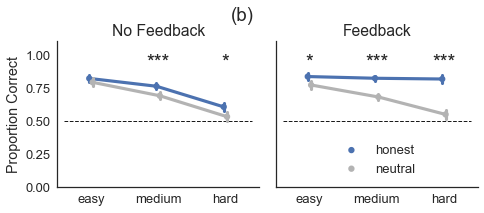

In [14]:
@plot(val='correct')
def plot_difficulty(df=ndf, val=None):
    g = sns.factorplot('difficulty', val, hue='cue', col='feedback',
                   data=df, **PK, legend=False)
    g.axes.flat[0].set_ylabel('Proportion Correct')
    g.axes.flat[1].legend(loc="lower center")
    
    for ax in g.axes.flat:
        ax.set_ylim(0, 1.1)
        ax.hlines(0.5, -0.4, 2.4, linestyles='--', lw=1)
        ax.set_xlabel('')
    feedback_labels(g)

    # Significicance
    def star(ax, x, p):
        n_star = 3 if p < .001 else 2 if p < .01 else 1 if p < .05 else 0
        if n_star:
            g.axes.flat[ax].text(x, 0.9, '*' * n_star, fontsize=20, horizontalalignment='center')
    
    for i, row in comps_tbl.ix[:6].iterrows():
        i -= 1
        if '<' in row.signif:
            star(i // 3, i % 3, row.p_value)

    plt.gcf().set_size_inches(7, 3)
    plt.suptitle('(b)', y=1)
    plt.tight_layout()